In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from helper_functions import *
importTensorflow(memory=4090)
precision()

2.13.0
1 Physical GPUs, 1 Logical GPUs
<Policy "mixed_float16">


In [2]:
import pandas as pd
df = pd.read_csv("depression_dataset_reddit_cleaned.csv")
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [3]:
train_df_shuffled = df.sample(frac=1, random_state=42).reset_index().drop(["index"], axis=1)
train_df_shuffled.head(10)

,clean_text,is_depression
0,my doctor think that sertaline is better for a...,1
1,must be depression fr,1
2,this ha ruined my life the only thing keeping ...,1
3,i am no job no career suffering from severe de...,1
4,endearingevania i sure wish i could go with yo...,0
5,bed is painfully tempting right now but if i t...,0
6,just called out of work today i m feeling like...,1
7,i don t feel like myself anymore and i don t t...,1
8,i live in my bedroom weekend burn by fast with...,1
9,my dad killed himself and it left me with a fe...,1


In [4]:
train_df = train_df_shuffled.loc[:int(0.99*len(train_df_shuffled))]
test_df = train_df_shuffled.loc[int(0.99*len(train_df_shuffled)):]

In [5]:
len(test_df)

78

In [6]:
train_df.head()

,clean_text,is_depression
0,my doctor think that sertaline is better for a...,1
1,must be depression fr,1
2,this ha ruined my life the only thing keeping ...,1
3,i am no job no career suffering from severe de...,1
4,endearingevania i sure wish i could go with yo...,0


In [7]:
train_df["is_depression"].value_counts()

is_depression
0    3865
1    3789
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["clean_text"].to_numpy(),
                                                                            train_df["is_depression"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [9]:
len(val_sentences)

766

In [10]:
import tensorflow_hub as hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embed = hub.load("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/universal-sentence-encoder/versions/1")

In [11]:
sentence_encoder_layer = hub.KerasLayer("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/universal-sentence-encoder/versions/1",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [12]:
model = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_history = model.fit(train_sentences,train_labels,
                               validation_data=(val_sentences,val_labels),
                               epochs=2)

Epoch 1/2
216/216 [==============================] - 5s 14ms/step - loss: 0.5457 - accuracy: 0.8701 - val_loss: 0.4329 - val_accuracy: 0.9413
Epoch 2/2
216/216 [==============================] - 3s 13ms/step - loss: 0.3630 - accuracy: 0.9467 - val_loss: 0.3134 - val_accuracy: 0.9491


<Axes: >

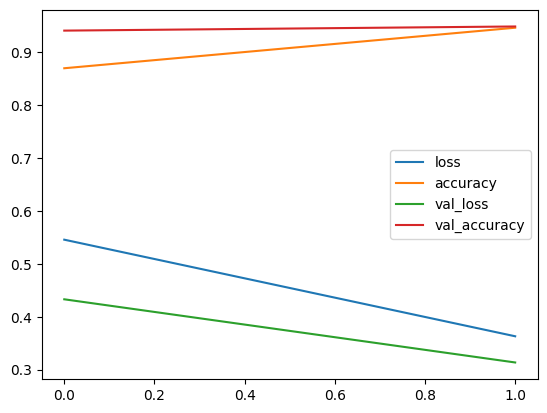

In [15]:
pd.DataFrame(model_history.history).plot()

In [16]:
model_preds_final = []
test_df['is_depression'] = test_df['is_depression'].astype(np.int64)

for i in range(len(test_df)):
    prediction = model.predict([test_df["clean_text"].iloc[i]])[0][0]
    model_preds_final.append(prediction)
    temp_df = pd.DataFrame([[test_df["clean_text"].iloc[i], test_df["is_depression"].iloc[i]]],
                           columns=['clean_text', 'is_depression'])
    train_df = pd.concat([train_df, temp_df], ignore_index=True)
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["clean_text"].to_numpy(),
                                                                                train_df["is_depression"].to_numpy(),
                                                                                test_size=0.1,
                                                                                random_state=42)
    model_history = model.fit(train_sentences, train_labels,
                               validation_data=(val_sentences, val_labels),
                               epochs=2, verbose =0)


1/1 [==============================] - 0s 141ms/step


/tmp/ipykernel_234825/2697740809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['is_depression'] = test_df['is_depression'].astype(np.int64)


1/1 [==============================] - 0s 23ms/step


In [17]:
model_preds_final

[0.35,
 0.737,
 0.0536,
 0.0557,
 0.0877,
 0.9727,
 0.096,
 0.999,
 0.04535,
 0.999,
 0.9463,
 0.999,
 0.00693,
 0.944,
 0.994,
 0.905,
 0.003136,
 0.0171,
 0.9717,
 0.0014105,
 0.996,
 0.01077,
 0.823,
 0.994,
 1.0,
 0.00512,
 1.0,
 0.999,
 0.0158,
 0.999,
 1.0,
 0.0074,
 1.0,
 0.981,
 0.994,
 1.0,
 0.01277,
 0.1022,
 0.999,
 0.999,
 1.0,
 0.999,
 0.002531,
 0.1976,
 0.0005794,
 0.967,
 0.037,
 0.966,
 0.1606,
 0.001004,
 0.08386,
 0.2064,
 0.0477,
 0.02069,
 0.04218,
 1.0,
 0.586,
 0.04922,
 1.0,
 0.999,
 1.0,
 0.8706,
 1.0,
 0.000955,
 0.001048,
 0.00401,
 0.0005636,
 1.0,
 0.01317,
 0.03552,
 0.86,
 0.998,
 0.001467,
 0.01791,
 0.002935,
 1.0,
 0.02296,
 0.007965]

In [26]:

threshold = 0.5  
binary_predictions = [1 if pred >= threshold else 0 for pred in model_preds_final]
ground_truth_labels = test_df["is_depression"].astype(np.float32)
accuracy_metric = tf.keras.metrics.Accuracy()
accuracy_metric.update_state(ground_truth_labels, binary_predictions)
accuracy_value = accuracy_metric.result().numpy()

print("Accuracy:", accuracy_value)

Accuracy: 0.96153843
